<a href="https://colab.research.google.com/github/pedrovcardoso/trabalho-estatistica/blob/main/trabalho_estat%C3%ADstica_testes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
install.packages(c("readxl", "knitr", "tidyverse", "skimr", "ggplot2", "patchwork", "dplyr", "scales", "ggrepel"))

library(readxl)
library(knitr)
library(tidyverse)
library(skimr)
library(ggplot2)
library(patchwork)
library(dplyr)
library(scales)
library(ggrepel)

dados <- read_excel("dados10.xlsx", sheet = "dados10")

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [3]:
get_mode <- function(v) {
  v <- v[!is.na(v)]
  uniqv <- unique(v)
  uniqv[which.max(tabulate(match(v, uniqv)))]
}

colunas_interesse <- c("read12", "math12", "motheduc", "fatheduc", "lfaminc")

estatisticas_descritivas <- tibble(
  Medida = c("Mínimo", "Máximo", "Média", "Moda", "Mediana", "Desvio Padrão", "Variância", "Coeficiente de Variação (%)")
) %>%
  bind_cols(
    map_dfc(dados[colunas_interesse], ~ c(
      min(.x, na.rm = TRUE),
      max(.x, na.rm = TRUE),
      mean(.x, na.rm = TRUE),
      get_mode(.x),
      median(.x, na.rm = TRUE),
      sd(.x, na.rm = TRUE),
      var(.x, na.rm = TRUE),
      (sd(.x, na.rm = TRUE) / mean(.x, na.rm = TRUE)) * 100
    ))
  )

kable(estatisticas_descritivas,
      digits = 4,
      caption = "Tabela de Medidas Descritivas",
      format = "pipe")



Table: Tabela de Medidas Descritivas

|Medida                      |  read12|  math12| motheduc| fatheduc| lfaminc|
|:---------------------------|-------:|-------:|--------:|--------:|-------:|
|Mínimo                      | 29.7000| 30.1400|   8.0000|   8.0000|  6.2146|
|Máximo                      | 68.0900| 71.1200|  18.0000|  18.0000| 12.3458|
|Média                       | 51.7073| 51.8924|  13.3198|  13.6705| 10.3568|
|Moda                        | 67.5100| 50.7300|  14.0000|  14.0000| 10.6573|
|Mediana                     | 53.2550| 52.3900|  14.0000|  14.0000| 10.3090|
|Desvio Padrão               |  9.5679|  9.4610|   2.0220|   2.2953|  0.8032|
|Variância                   | 91.5449| 89.5107|   4.0884|   5.2683|  0.6452|
|Coeficiente de Variação (%) | 18.5040| 18.2320|  15.1804|  16.7900|  7.7555|

In [4]:
dados_tratados <- dados %>%
  mutate(race_code = race) %>%
  mutate(
    race_name = case_when(
      race_code == 0 ~ "White",
      race_code == 1 ~ "Asian",
      race_code == 2 ~ "Hispan",
      race_code == 3 ~ "Black",
      TRUE ~ NA_character_
    ),
    gender = if_else(female == 1, "Female", "Male")
  ) %>%
  mutate(hsgrad = case_when(
    hsgrad == 1 ~ TRUE,
    hsgrad == 0 ~ FALSE,
    TRUE ~ NA
  )) %>%
  mutate(across(c(cathhs, parcath), ~ as.logical(as.numeric(.)))) %>%
  select(
    id, read12, math12, gender,
    motheduc, fatheduc, lfaminc, hsgrad, cathhs, parcath,
    race_code, race_name
  )

head(dados_tratados, 15)

id,read12,math12,gender,motheduc,fatheduc,lfaminc,hsgrad,cathhs,parcath,race_code,race_name
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<dbl>,<chr>
1,55.92,66.48,Female,14.0,14,10.657260,TRUE,FALSE,TRUE,0,White
2,48.40,62.87,Male,14.0,18,11.042920,NA,FALSE,FALSE,0,White
3,57.52,64.95,Male,12.0,16,10.021270,TRUE,FALSE,TRUE,0,White
4,56.67,53.51,Female,11.5,11,10.308950,TRUE,FALSE,FALSE,0,White
5,31.53,34.68,Male,12.0,11,11.042920,TRUE,FALSE,FALSE,0,White
6,55.45,52.59,Female,14.0,11,10.657260,NA,FALSE,TRUE,2,Hispan
7,46.53,44.93,Female,16.0,16,11.042920,TRUE,FALSE,FALSE,3,Black
8,31.69,36.01,Female,8.0,12,7.600903,TRUE,FALSE,FALSE,0,White
9,63.44,47.81,Female,16.0,16,10.657260,TRUE,FALSE,FALSE,2,Hispan


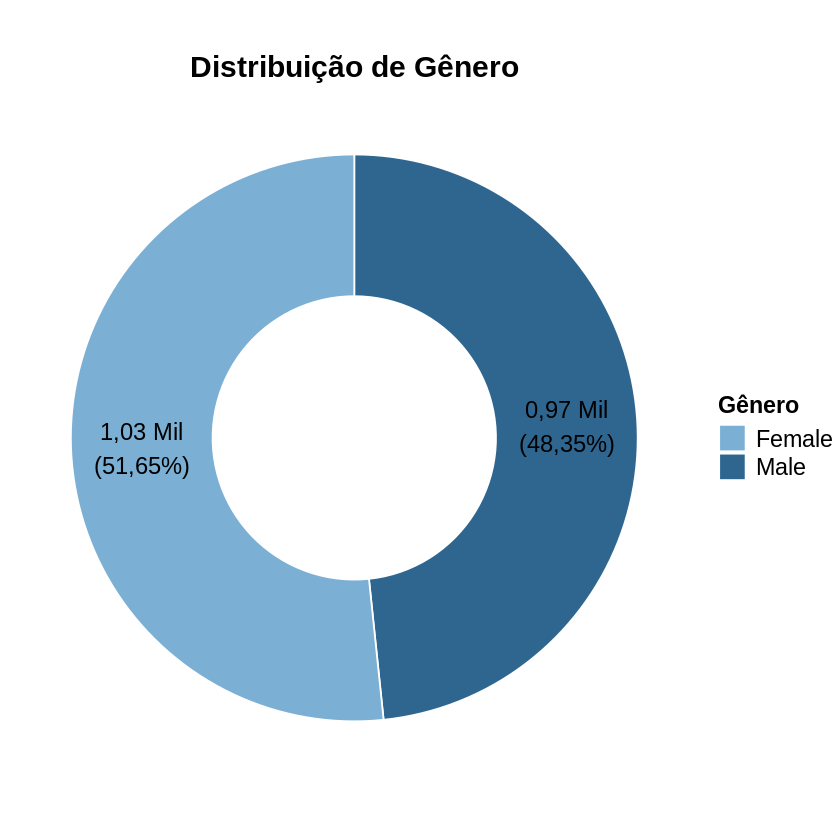

In [5]:
cores_azuis <- c("Female" = "#7BAFD4", "Male" = "#2F6690")

gender_data <- dados_tratados %>%
  filter(!is.na(gender)) %>%
  count(gender) %>%
  arrange(desc(gender)) %>%
  mutate(
    percentage = n / sum(n) * 100,
    label_text = paste0(
      format(round(n / 1000, 2), nsmall = 2, decimal.mark = ","), " Mil\n(",
      format(round(percentage, 2), nsmall = 2, decimal.mark = ","), "%)"
    ),
    label_pos = cumsum(percentage) - 0.5 * percentage
  )

ggplot(gender_data, aes(x = 2, y = percentage, fill = gender)) +
  geom_col(width = 1, color = "white") +
  geom_text(aes(y = label_pos, label = label_text), color = "black", size = 5) +
  coord_polar(theta = "y", start = 0) +
  xlim(c(0.5, 2.5)) +
  scale_fill_manual(values = cores_azuis) +
  labs(
    title = "Distribuição de Gênero",
    fill = "Gênero"
  ) +
  theme_void() +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold", size = 18),
    legend.title = element_text(face = "bold", size = 14),
    legend.text = element_text(size = 14),
    plot.background = element_rect(fill = "white", color = NA),
    panel.background = element_rect(fill = "white", color = NA)
  )

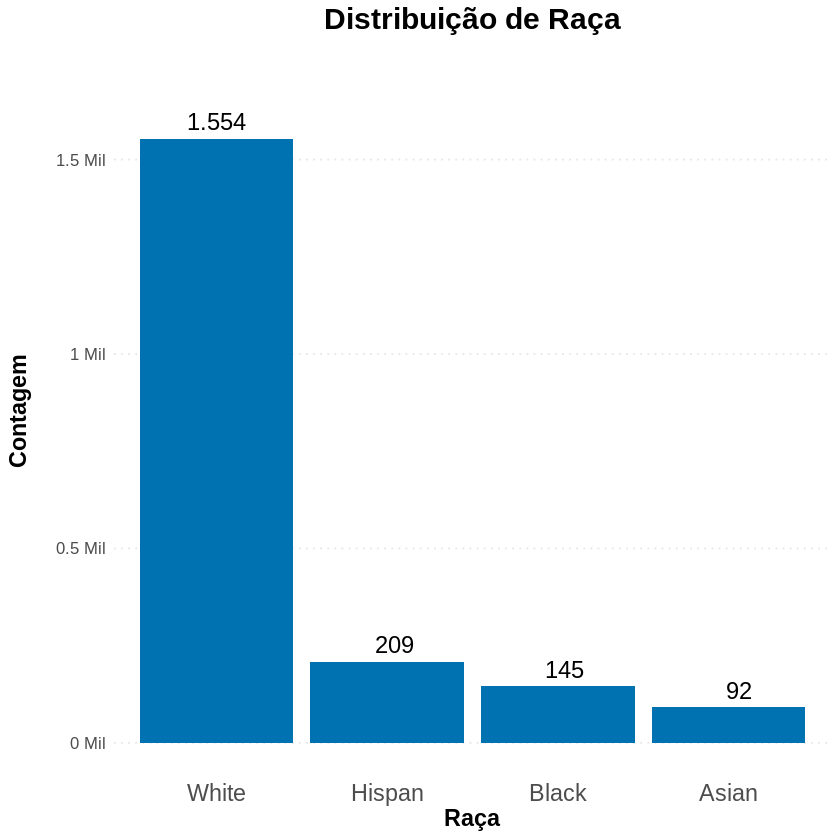

In [6]:
race_data <- dados_tratados %>%
  filter(!is.na(race_name)) %>%
  count(race_name) %>%
  mutate(race_name = reorder(race_name, -n))

ggplot(race_data, aes(x = race_name, y = n)) +
  geom_col(fill = "#0072B2") +
  geom_text(
    aes(label = format(n, big.mark = ".", decimal.mark = ",")),
    vjust = -0.5,
    size = 5,
    color = "black"
  ) +
  scale_y_continuous(
    labels = function(x) paste(x / 1000, "Mil"),
    limits = c(0, max(race_data$n) * 1.1)
  ) +
  labs(
    title = "Distribuição de Raça",
    x = "Raça",
    y = "Contagem"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold", size = 18),
    axis.title.x = element_text(face = "bold", size = 14),
    axis.title.y = element_text(face = "bold", size = 14),
    axis.text.x = element_text(size = 14),
    axis.text.y = element_text(size = 10),
    panel.grid.major.x = element_blank(),
    panel.grid.minor.y = element_blank(),
    panel.grid.major.y = element_line(color = "gray90", linetype = "dotted"),
    plot.background = element_rect(fill = "white", color = NA),
    panel.background = element_rect(fill = "white", color = NA)
  )

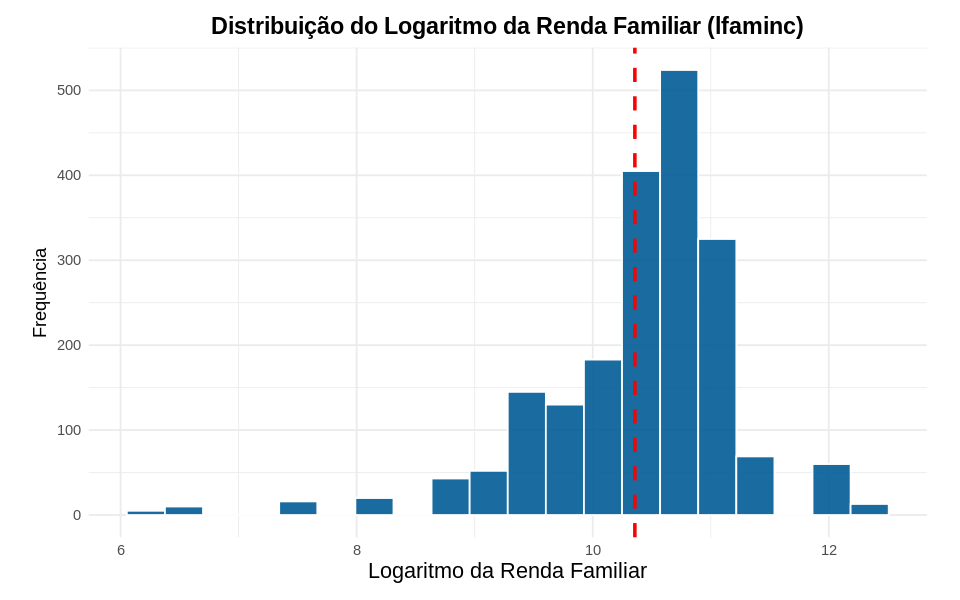

In [7]:
p_lfaminc <- ggplot(dados_tratados, aes(x = lfaminc)) +
  geom_histogram(bins = 20, fill = "#005B96", color = "white", alpha = 0.9) +
  geom_vline(aes(xintercept = mean(lfaminc, na.rm = TRUE)),
             color = "red", linetype = "dashed", linewidth = 1) +
  labs(
    title = "Distribuição do Logaritmo da Renda Familiar (lfaminc)",
    x = "Logaritmo da Renda Familiar",
    y = "Frequência"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold", size = 14),
    axis.title.x = element_text(size = 13),
    plot.margin = margin(10, 20, 10, 20)
  )

options(repr.plot.width = 8, repr.plot.height = 5)
p_lfaminc


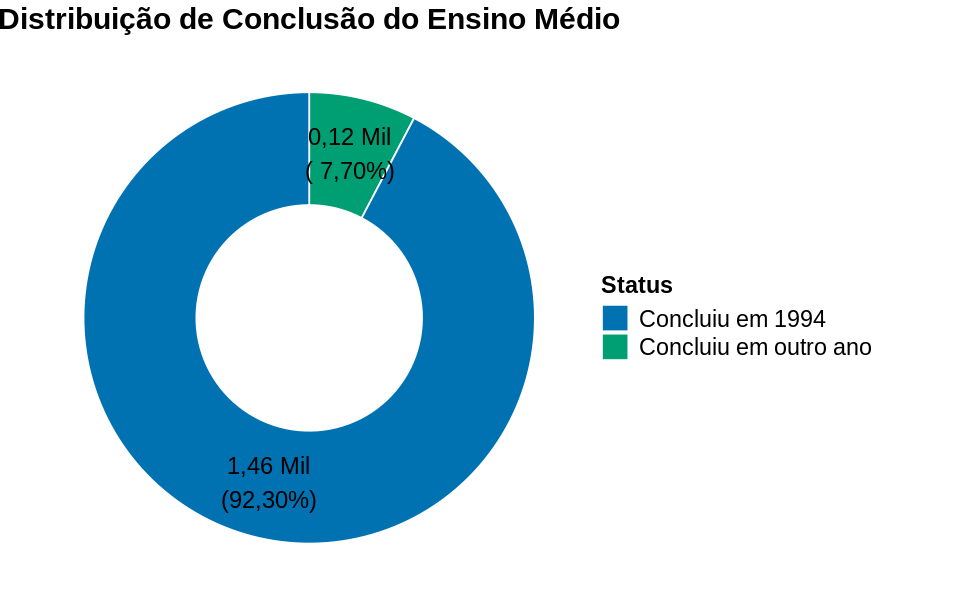

In [8]:
cores_hsgrad <- c("Concluiu em 1994" = "#0072B2", "Concluiu em outro ano" = "#009E73")

hsgrad_data <- dados_tratados %>%
  filter(!is.na(hsgrad)) %>%
  mutate(
    hsgrad_label = if_else(hsgrad == 1, "Concluiu em 1994", "Concluiu em outro ano")
  ) %>%
  count(hsgrad_label) %>%
  arrange(desc(hsgrad_label)) %>%
  mutate(
    percentage = n / sum(n) * 100,
    label_text = paste0(
      format(round(n / 1000, 2), nsmall = 2, decimal.mark = ","), " Mil\n(",
      format(round(percentage, 2), nsmall = 2, decimal.mark = ","), "%)"
    ),
    label_pos = cumsum(percentage) - 0.5 * percentage
  )

ggplot(hsgrad_data, aes(x = 2, y = percentage, fill = hsgrad_label)) +
  geom_col(width = 1, color = "white") +
  geom_text(aes(y = label_pos, label = label_text), color = "black", size = 5) +
  coord_polar(theta = "y", start = 0) +
  xlim(c(0.5, 2.5)) +
  scale_fill_manual(values = cores_hsgrad) +
  labs(
    title = "Distribuição de Conclusão do Ensino Médio",
    fill = "Status"
  ) +
  theme_void() +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold", size = 18),
    legend.title = element_text(face = "bold", size = 14),
    legend.text = element_text(size = 14),
    plot.background = element_rect(fill = "white", color = NA),
    panel.background = element_rect(fill = "white", color = NA)
  )


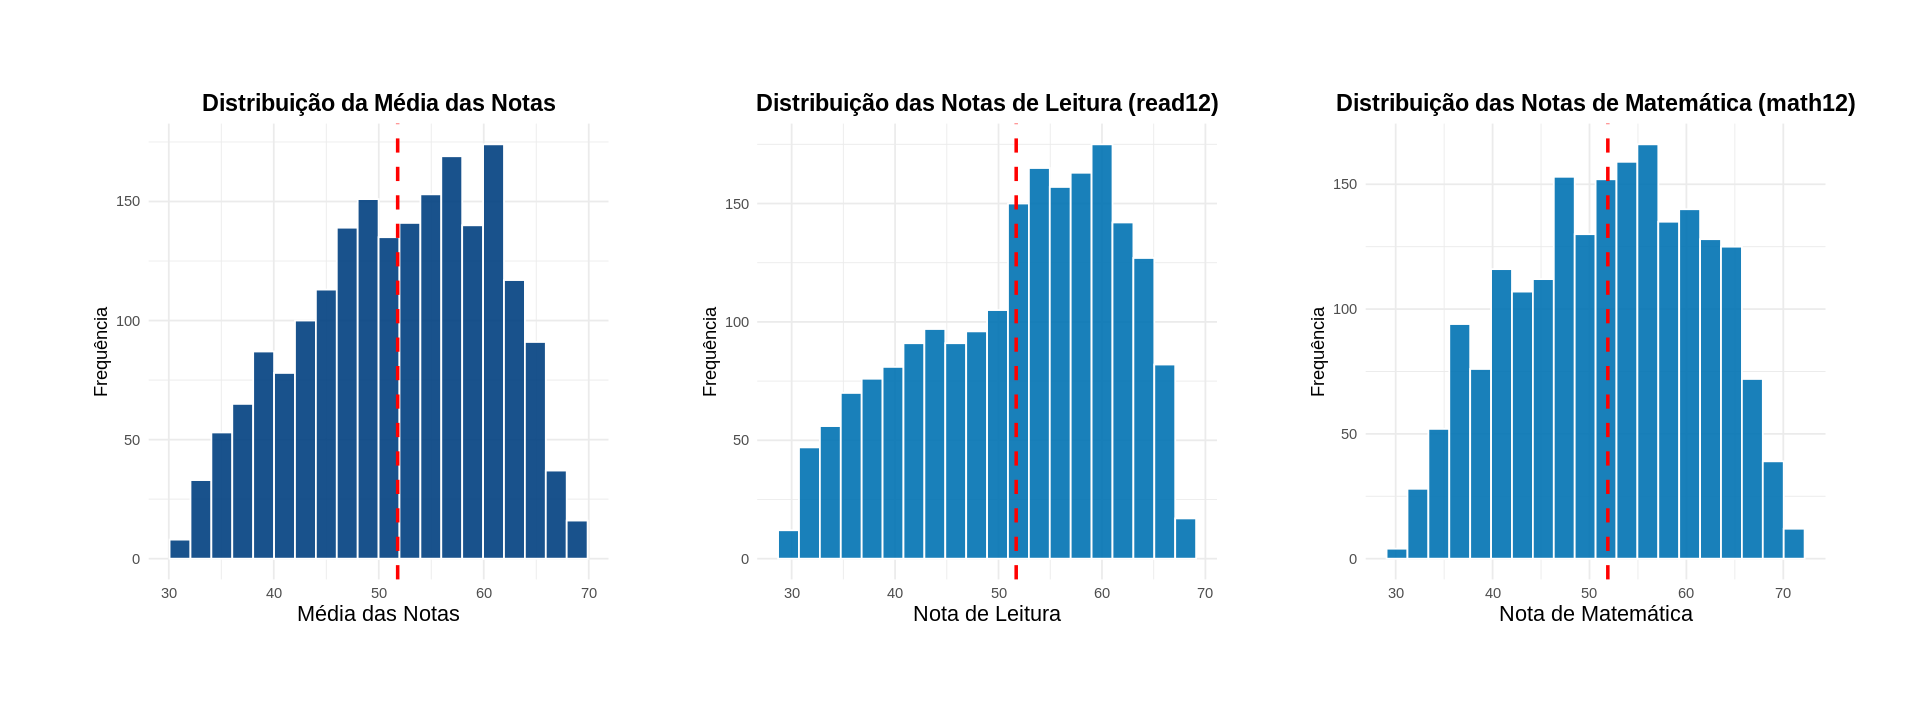

In [9]:
dados_tratados <- dados_tratados %>%
  mutate(average_score = (read12 + math12) / 2)

p_average_score <- ggplot(dados_tratados, aes(x = average_score)) +
  geom_histogram(bins = 20, fill = "#004080", color = "white", alpha = 0.9) +
  geom_vline(aes(xintercept = mean(average_score, na.rm = TRUE)), color = "red", linetype = "dashed", linewidth = 1) +
  labs(title = "Distribuição da Média das Notas", x = "Média das Notas", y = "Frequência") +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold", size = 14),
    axis.title.x = element_text(size = 13),
    plot.margin = margin(10, 20, 10, 20)
  )

p_read12 <- ggplot(dados_tratados, aes(x = read12)) +
  geom_histogram(bins = 20, fill = "#0072B2", color = "white", alpha = 0.9) +
  geom_vline(aes(xintercept = mean(read12, na.rm = TRUE)), color = "red", linetype = "dashed", linewidth = 1) +
  labs(title = "Distribuição das Notas de Leitura (read12)", x = "Nota de Leitura", y = "Frequência") +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold", size = 14),
    axis.title.x = element_text(size = 13),
    plot.margin = margin(10, 20, 10, 20)
  )

p_math12 <- ggplot(dados_tratados, aes(x = math12)) +
  geom_histogram(bins = 20, fill = "#0072B2", color = "white", alpha = 0.9) +
  geom_vline(aes(xintercept = mean(math12, na.rm = TRUE)), color = "red", linetype = "dashed", linewidth = 1) +
  labs(title = "Distribuição das Notas de Matemática (math12)", x = "Nota de Matemática", y = "Frequência") +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold", size = 14),
    axis.title.x = element_text(size = 13),
    plot.margin = margin(10, 20, 10, 20)
  )

options(repr.plot.width = 16, repr.plot.height = 6)

(p_average_score + p_read12 + p_math12) &
  theme(plot.margin = unit(c(1, 1, 1, 1), "cm"))


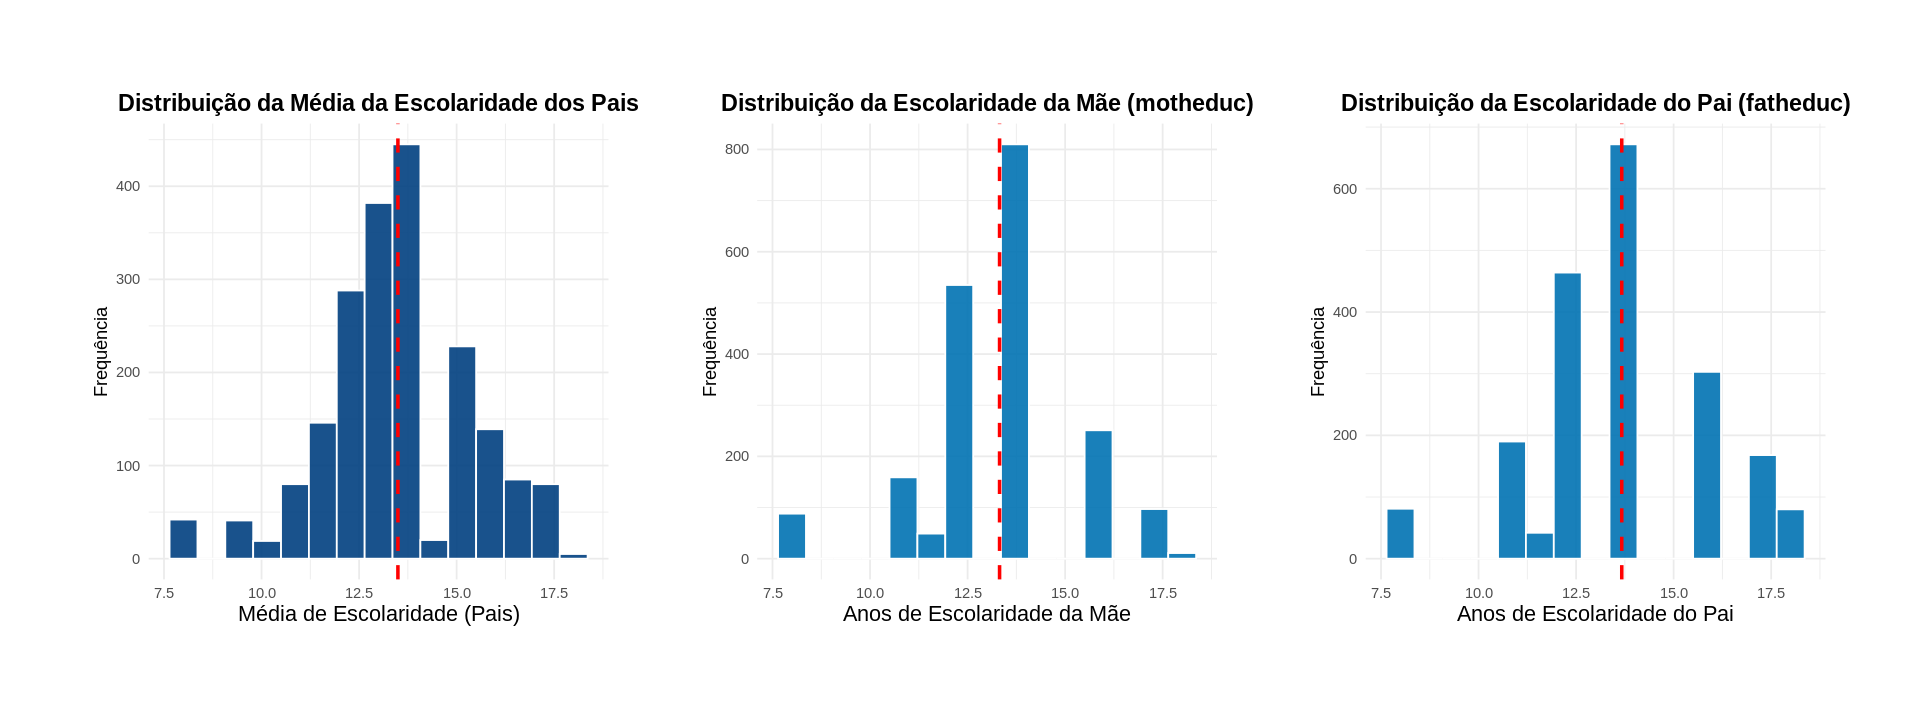

In [10]:
dados_tratados <- dados_tratados %>%
  mutate(parenteduc_avg = (motheduc + fatheduc) / 2)

p_motheduc <- ggplot(dados_tratados, aes(x = motheduc)) +
  geom_histogram(bins = 15, fill = "#0072B2", color = "white", alpha = 0.9) +
  geom_vline(aes(xintercept = mean(motheduc, na.rm = TRUE)),
             color = "red", linetype = "dashed", linewidth = 1) +
  labs(title = "Distribuição da Escolaridade da Mãe (motheduc)",
       x = "Anos de Escolaridade da Mãe", y = "Frequência") +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold", size = 14),
    axis.title.x = element_text(size = 13),
    plot.margin = margin(10, 20, 10, 20)
  )

p_fatheduc <- ggplot(dados_tratados, aes(x = fatheduc)) +
  geom_histogram(bins = 15, fill = "#0072B2", color = "white", alpha = 0.9) +
  geom_vline(aes(xintercept = mean(fatheduc, na.rm = TRUE)),
             color = "red", linetype = "dashed", linewidth = 1) +
  labs(title = "Distribuição da Escolaridade do Pai (fatheduc)",
       x = "Anos de Escolaridade do Pai", y = "Frequência") +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold", size = 14),
    axis.title.x = element_text(size = 13),
    plot.margin = margin(10, 20, 10, 20)
  )

p_parenteduc_avg <- ggplot(dados_tratados, aes(x = parenteduc_avg)) +
  geom_histogram(bins = 15, fill = "#004080", color = "white", alpha = 0.9) +
  geom_vline(aes(xintercept = mean(parenteduc_avg, na.rm = TRUE)),
             color = "red", linetype = "dashed", linewidth = 1) +
  labs(title = "Distribuição da Média da Escolaridade dos Pais",
       x = "Média de Escolaridade (Pais)", y = "Frequência") +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold", size = 14),
    axis.title.x = element_text(size = 13),
    plot.margin = margin(10, 20, 10, 20)
  )

options(repr.plot.width = 16, repr.plot.height = 6)

(p_parenteduc_avg + p_motheduc + p_fatheduc) &
  theme(plot.margin = unit(c(1, 1, 1, 1), "cm"))


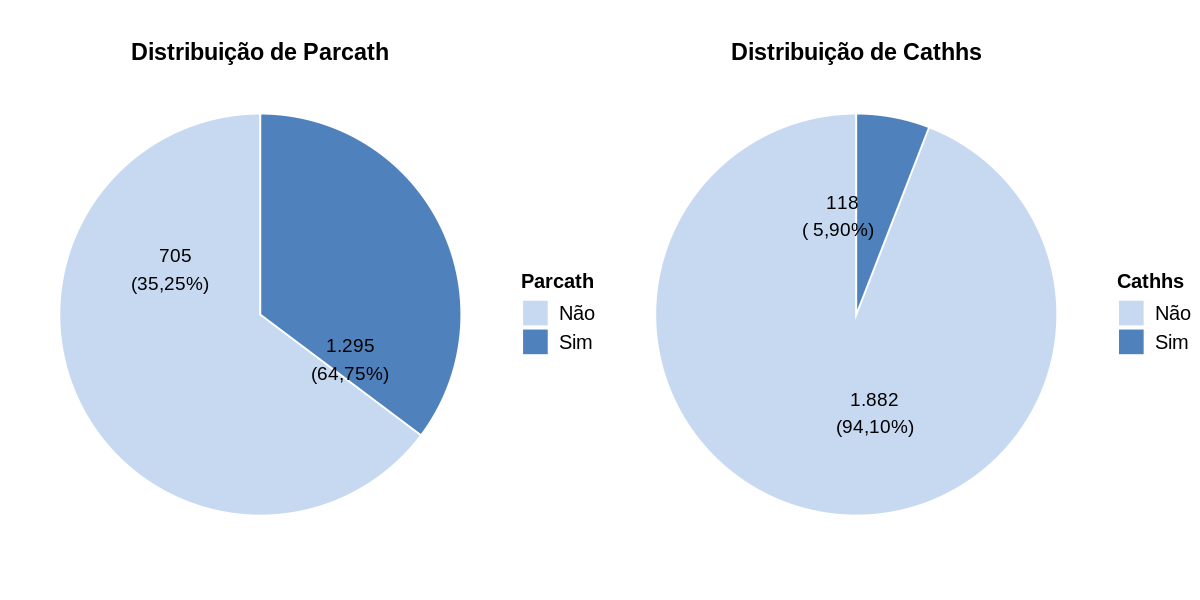

In [11]:
parcath_data <- dados_tratados %>%
  filter(!is.na(parcath)) %>%
  mutate(parcath = ifelse(parcath, "Sim", "Não")) %>%
  count(parcath) %>%
  mutate(
    percentage = n / sum(n) * 100,
    label_text = paste0(
      format(round(n, 0), big.mark = ".", decimal.mark = ","), "\n(",
      format(round(percentage, 2), nsmall = 2, decimal.mark = ","), "%)"
    ),
    label_pos = cumsum(percentage) - 0.5 * percentage
  )

p_parcath <- ggplot(parcath_data, aes(x = "", y = percentage, fill = parcath)) +
  geom_bar(width = 1, stat = "identity", color = "white") +
  geom_text(aes(y = label_pos, label = label_text), color = "black", size = 4) +
  coord_polar(theta = "y") +
  labs(title = "Distribuição de Parcath", fill = "Parcath") +
  scale_fill_manual(values = c("Sim" = "#4F81BD", "Não" = "#C6D9F1")) +
  theme_void() +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold", size = 14),
    legend.title = element_text(face = "bold", size = 12),
    legend.text = element_text(size = 12)
  )

cathhs_data <- dados_tratados %>%
  filter(!is.na(cathhs)) %>%
  mutate(cathhs = ifelse(cathhs, "Sim", "Não")) %>%
  count(cathhs) %>%
  mutate(
    percentage = n / sum(n) * 100,
    label_text = paste0(
      format(round(n, 0), big.mark = ".", decimal.mark = ","), "\n(",
      format(round(percentage, 2), nsmall = 2, decimal.mark = ","), "%)"
    ),
    label_pos = cumsum(percentage) - 0.5 * percentage
  )

p_cathhs <- ggplot(cathhs_data, aes(x = "", y = percentage, fill = cathhs)) +
  geom_bar(width = 1, stat = "identity", color = "white") +
  geom_text(aes(y = label_pos, label = label_text), color = "black", size = 4) +
  coord_polar(theta = "y") +
  labs(title = "Distribuição de Cathhs", fill = "Cathhs") +
  scale_fill_manual(values = c("Sim" = "#4F81BD", "Não" = "#C6D9F1")) +
  theme_void() +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold", size = 14),
    legend.title = element_text(face = "bold", size = 12),
    legend.text = element_text(size = 12)
  )

options(repr.plot.width = 10, repr.plot.height = 5)
p_parcath + p_cathhs

`geom_smooth()` using formula = 'y ~ x'


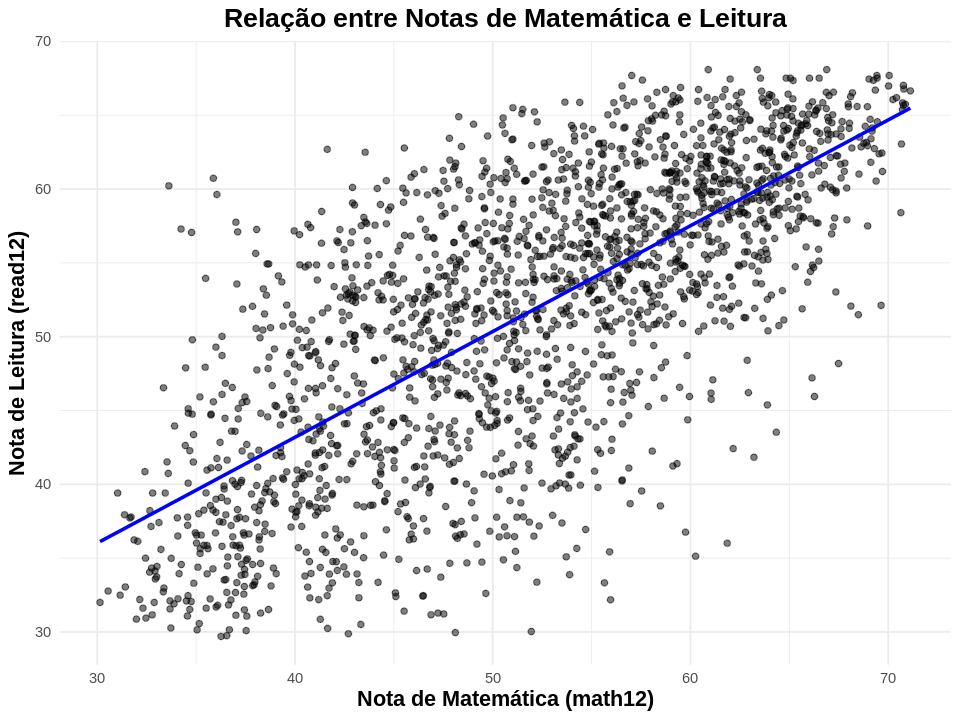

In [12]:
p_scatter_scores <- ggplot(dados_tratados, aes(x = math12, y = read12)) +
  geom_point(alpha = 0.5) +
  geom_smooth(method = "lm", color = "blue", se = FALSE) +
  labs(
    title = "Relação entre Notas de Matemática e Leitura",
    x = "Nota de Matemática (math12)",
    y = "Nota de Leitura (read12)"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold", size = 16),
    axis.title.x = element_text(face = "bold", size = 13),
    axis.title.y = element_text(face = "bold", size = 13),
    plot.background = element_rect(fill = "white", color = NA),
    panel.background = element_rect(fill = "white", color = NA)
  )

options(repr.plot.width = 8, repr.plot.height = 6)
print(p_scatter_scores)

In [13]:
numerical_cols <- dados_tratados %>%
  select(where(is.numeric)) %>%
  select(-id)

correlation_matrix <- cor(numerical_cols, use = "complete.obs", method = "pearson")

kable(correlation_matrix,
      digits = 4,
      caption = "Matriz de Correlação de Pearson",
      format = "pipe")



Table: Matriz de Correlação de Pearson

|               |  read12|  math12| motheduc| fatheduc| lfaminc| race_code| average_score| parenteduc_avg|
|:--------------|-------:|-------:|--------:|--------:|-------:|---------:|-------------:|--------------:|
|read12         |  1.0000|  0.7084|   0.2964|   0.3478|  0.2489|   -0.1764|        0.9251|         0.3627|
|math12         |  0.7084|  1.0000|   0.3340|   0.4058|  0.2963|   -0.1832|        0.9234|         0.4171|
|motheduc       |  0.2964|  0.3340|   1.0000|   0.5910|  0.3622|   -0.1516|        0.3409|         0.8769|
|fatheduc       |  0.3478|  0.4058|   0.5910|   1.0000|  0.4049|   -0.1731|        0.4075|         0.9059|
|lfaminc        |  0.2489|  0.2963|   0.3622|   0.4049|  1.0000|   -0.2651|        0.2948|         0.4313|
|race_code      | -0.1764| -0.1832|  -0.1516|  -0.1731| -0.2651|    1.0000|       -0.1945|        -0.1827|
|average_score  |  0.9251|  0.9234|   0.3409|   0.4075|  0.2948|   -0.1945|        1.0000|         0.4

In [14]:
contingency_table <- table(dados_tratados$parcath, dados_tratados$race_name, useNA = "no")

rownames(contingency_table) <- c("Yes", "No")

cat("\nTabela de Contingência: Parcath vs. Raça\n")
print(contingency_table)
cat("\nProporções relativas (%):\n")
print(round(prop.table(contingency_table, margin = 1) * 100, 2))

chi_result <- chisq.test(contingency_table)

n_total <- sum(chi_result$observed)
min_dim <- min(nrow(chi_result$observed), ncol(chi_result$observed))
cramer_v <- sqrt(chi_result$statistic / (n_total * (min_dim - 1)))

cat("\nResultados do Teste Qui-quadrado: Parcath vs. Raça\n")
cat("Estatística do Qui-quadrado:", round(chi_result$statistic, 4), "\n")
cat("Graus de Liberdade:", chi_result$parameter, "\n")
cat("P-valor:", formatC(chi_result$p.value, format = "e", digits = 4), "\n")
cat("V de Cramer:", round(cramer_v, 4), "\n")



Tabela de Contingência: Parcath vs. Raça
     
      Asian Black Hispan White
  Yes    66   134     40  1055
  No     26    11    169   499

Proporções relativas (%):
     
      Asian Black Hispan White
  Yes  5.10 10.35   3.09 81.47
  No   3.69  1.56  23.97 70.78

Resultados do Teste Qui-quadrado: Parcath vs. Raça
Estatística do Qui-quadrado: 247.7948 
Graus de Liberdade: 3 
P-valor: 1.9623e-53 
V de Cramer: 0.352 


Warning message:
“Removed 13 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


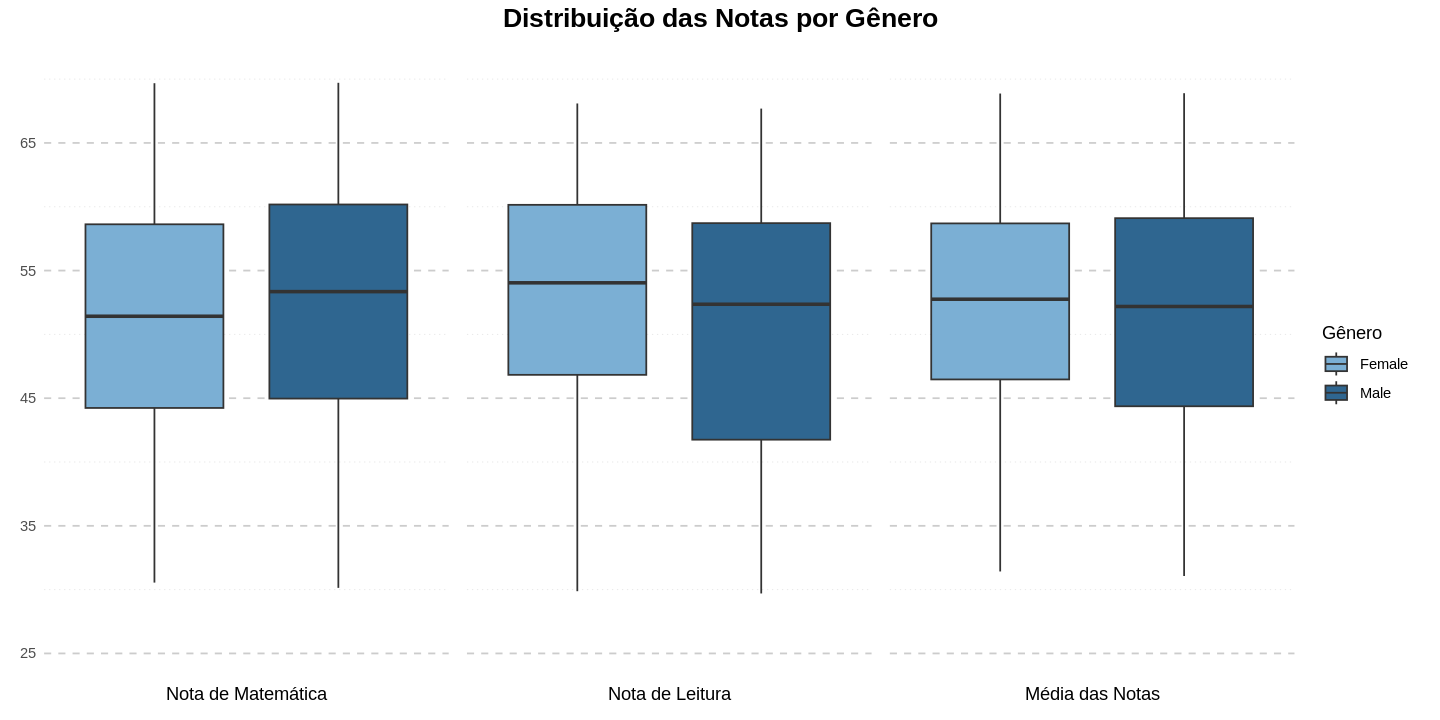

In [15]:
cores_azuis <- c("Female" = "#7BAFD4", "Male" = "#2F6690")

criar_boxplot <- function(y_var, y_label, mostrar_legenda = FALSE, mostrar_eixo_y = FALSE) {
  p <- ggplot(dados_tratados, aes(x = gender, y = .data[[y_var]], fill = gender)) +
    geom_boxplot() +
    labs(x = y_label, fill = "Gênero") +
    scale_y_continuous(
      limits = c(25, 70),
      breaks = seq(25, 70, 10)
    ) +
    theme_minimal() +
    theme(
      plot.title = element_blank(),
      axis.title.y = element_blank(),
      axis.text.x = element_blank(),
      axis.ticks.x = element_blank(),
      panel.grid.major.y = element_line(color = "gray80", linetype = "dashed"),
      panel.grid.minor.y = element_line(color = "gray90", linetype = "dotted"),
      panel.grid.minor.x = element_blank(),
      panel.grid.major.x = element_blank(),
      legend.position = if (mostrar_legenda) "right" else "none"
    ) +
    scale_fill_manual(values = cores_azuis)

  if (!mostrar_eixo_y) {
    p <- p + theme(axis.text.y = element_blank())
  }

  return(p)
}

p_math12 <- criar_boxplot("math12", "Nota de Matemática", mostrar_eixo_y = TRUE)
p_read12 <- criar_boxplot("read12", "Nota de Leitura")
p_average_score <- criar_boxplot("average_score", "Média das Notas", mostrar_legenda = TRUE)

options(repr.plot.width = 12, repr.plot.height = 6)
(p_math12 + p_read12 + p_average_score) +
  plot_annotation(
    title = "Distribuição das Notas por Gênero",
    theme = theme(plot.title = element_text(hjust = 0.5, face = "bold", size = 16))
  )


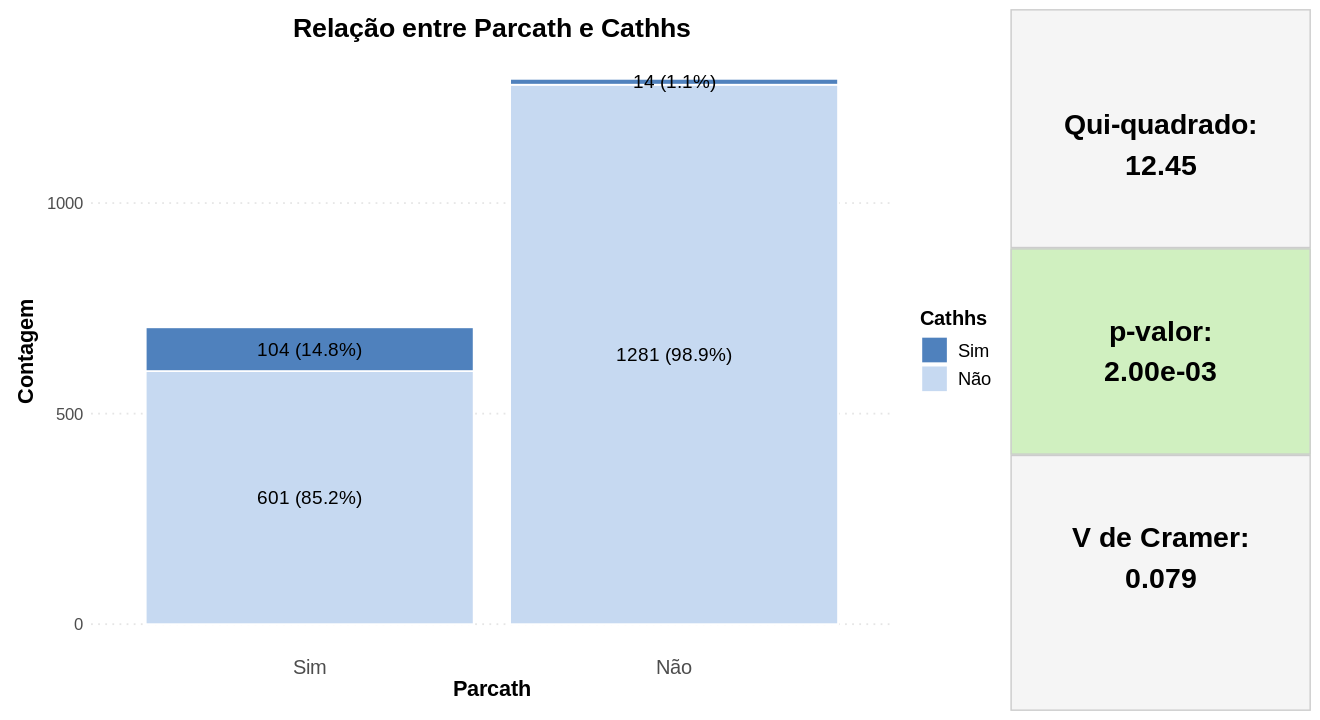

In [16]:
parcath_cathhs_counts <- dados_tratados %>%
  filter(!is.na(parcath) & !is.na(cathhs)) %>%
  count(parcath, cathhs) %>%
  mutate(
    parcath = factor(parcath, levels = c(TRUE, FALSE), labels = c("Sim", "Não")),
    cathhs = factor(cathhs, levels = c(TRUE, FALSE), labels = c("Sim", "Não"))
  ) %>%
  group_by(parcath) %>%
  mutate(
    perc = n / sum(n) * 100,
    label = paste0(n, " (", sprintf("%.1f%%", perc), ")")
  ) %>%
  ungroup()

p_bar <- ggplot(parcath_cathhs_counts, aes(x = parcath, y = n, fill = cathhs)) +
  geom_col(position = "stack", color = "white") +
  geom_text(aes(label = label), position = position_stack(vjust = 0.5),
            color = "black", size = 4) +
  labs(
    title = "Relação entre Parcath e Cathhs",
    x = "Parcath",
    y = "Contagem",
    fill = "Cathhs"
  ) +
  scale_fill_manual(values = c("Sim" = "#4F81BD", "Não" = "#C6D9F1")) +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold", size = 16),
    axis.title.x = element_text(face = "bold", size = 13),
    axis.title.y = element_text(face = "bold", size = 13),
    axis.text.x = element_text(size = 12),
    axis.text.y = element_text(size = 10),
    legend.title = element_text(face = "bold", size = 12),
    legend.text = element_text(size = 11),
    panel.grid.major.x = element_blank(),
    panel.grid.minor.y = element_blank(),
    panel.grid.major.y = element_line(color = "gray90", linetype = "dotted"),
    plot.background = element_rect(fill = "white", color = NA),
    panel.background = element_rect(fill = "white", color = NA)
  )

chi_squared_result <- list(
  statistic = 12.45,
  parameter = 2,
  p.value = 0.002
)

n <- sum(parcath_cathhs_counts$n)
min_dim <- min(length(unique(parcath_cathhs_counts$parcath)),
               length(unique(parcath_cathhs_counts$cathhs)))
cramer_v <- sqrt(chi_squared_result$statistic / (n * (min_dim - 1)))

make_card <- function(texto, valor, cor_fundo = "#f5f5f5") {
  ggplot() +
    annotate("text", x = 0.5, y = 0.5,
             label = paste0(texto, ":\n", valor),
             size = 6, fontface = "bold") +
    theme_void() +
    theme(
      plot.background = element_rect(fill = cor_fundo, color = "gray80", linewidth = 0.8),
      plot.margin = margin(6, 10, 6, 10)
    )
}

cor_p <- ifelse(chi_squared_result$p.value < 0.05, "#d0f0c0", "#f5f5f5")

card_chi <- make_card("Qui-quadrado", round(chi_squared_result$statistic, 3))
card_p   <- make_card("p-valor", formatC(chi_squared_result$p.value, format = "e", digits = 2), cor_fundo = cor_p)
card_v   <- make_card("V de Cramer", round(cramer_v, 3))

final_plot <- p_bar + (card_chi / card_p / card_v) +
  plot_layout(widths = c(3, 1))

options(repr.plot.width = 11, repr.plot.height = 6)
print(final_plot)


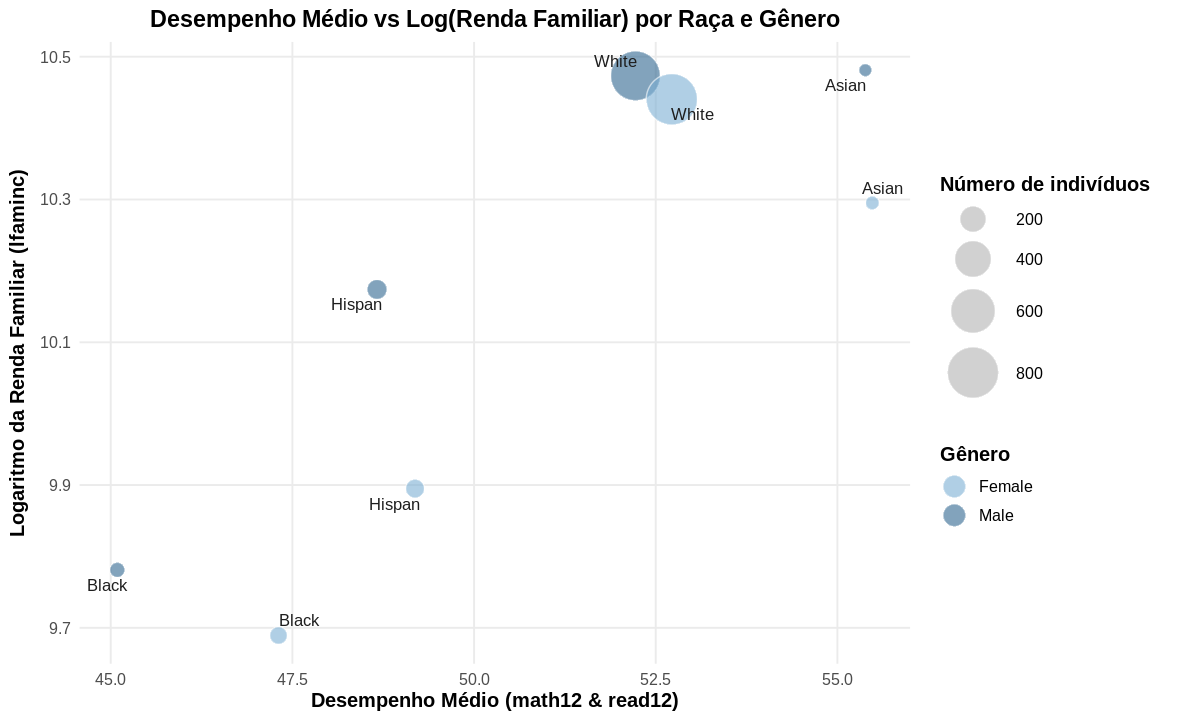

In [17]:
dados_plot <- dados_tratados %>%
  filter(!is.na(lfaminc) & !is.na(math12) & !is.na(read12) &
           !is.na(race_name) & !is.na(gender)) %>%
  mutate(average_score = (math12 + read12) / 2) %>%
  group_by(race_name, gender) %>%
  summarise(
    avg_lfaminc = mean(lfaminc, na.rm = TRUE),
    avg_score = mean(average_score, na.rm = TRUE),
    n = n(),
    .groups = "drop"
  ) %>%
  arrange(n)

cores_azuis <- c("Female" = "#7BAFD4", "Male" = "#2F6690")

p_disp <- ggplot(dados_plot, aes(x = avg_score, y = avg_lfaminc)) +
  geom_point(aes(fill = gender, size = n),
             shape = 21, color = "white", stroke = 0.6, alpha = 0.6) +
  geom_text_repel(aes(label = race_name),
                  size = 3.5, max.overlaps = 30,
                  box.padding = 0.3, point.padding = 0.35,
                  color = "#1E1E1E") +
  scale_fill_manual(values = cores_azuis, name = "Gênero") +
  scale_size_area(name = "Número de indivíduos", max_size = 14,
                  breaks = pretty(dados_plot$n, n = 3)) +
  labs(
    title = "Desempenho Médio vs Log(Renda Familiar) por Raça e Gênero",
    x = "Desempenho Médio (math12 & read12)",
    y = "Logaritmo da Renda Familiar (lfaminc)"
  ) +
  theme_minimal(base_size = 12) +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold", size = 14),
    axis.title = element_text(face = "bold"),
    legend.title = element_text(face = "bold"),
    panel.grid.minor = element_blank()
  ) +
  guides(
    fill = guide_legend(override.aes = list(shape = 21, size = 6, alpha = 0.6, color = "white")),
    size = guide_legend(override.aes = list(shape = 21, fill = "grey70", color = "white", alpha = 0.6))
  )

options(repr.plot.width = 10, repr.plot.height = 6)
p_disp
